# Plot MFT prediction of input response of unstructured network

For inputs to all, single, or $Q$ populations, as function of $D$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_plot

In [2]:
# numeric params for computing MF quantities
DX = .05
X_MIN = -20
X_MAX = 150

X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    if sgm == 0:
        temp = np.zeros(X.shape)
        temp[np.argmin(np.abs(X))] = 1/DX
        return temp
    
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    if sgm == 0:
        temp = (X >= 0).astype(float)
        temp[X == 0] = .5
        return temp
    
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def alph(th, u, v, D, mu_j, sgm_j, N=np.inf):
    """
    th \in [0, 1]^D
    u \in R^D
    v \in R_+^D
    D scalar
    mu_j \in R^{DxD}
    sgm_j \in R^{DxD}
    """
    mu_d = D*(mu_j @ th) + u
    sgm_d = np.sqrt(D*((sgm_j**2)@th) + v)
    
    phis = np.array([phi(X, mu_d_, sgm_d_) for mu_d_, sgm_d_ in zip(mu_d, sgm_d)])
    
    mnot_d = ~np.eye(len(th), dtype=bool) # masks for selecting all but one d
    
    th_next = np.nan*np.zeros(D)
    for d, (mu_d_, sgm_d_) in enumerate(zip(mu_d, sgm_d)):
        
        mask_d = mnot_d[d]
        th_next[d] = min(np.sum(norm(X, mu_d_, sgm_d_) * np.prod(phis[mask_d, :], axis=0))*DX, 1)
        
    if np.isinf(N):
        return th_next
    else:
        return np.random.multinomial(N, th_next)/N

In [3]:
NS = [np.inf, 2000]
U_SCALES = np.arange(0, 12.5, 0.5)
T_MAX = 21
t = np.arange(T_MAX)
t_u = 5

DS = [2, 3, 4, 8, 20, 50]
NPPLN_STIMS = [1, 2, 4, 'all']

In [4]:
PLOT = False

fr_1s = np.nan*np.zeros((len(NPPLN_STIMS), len(DS), len(NS), len(U_SCALES)))  # firing rate of first co-tuned ppln

for cD, D in enumerate(DS):
    sys.stdout.write(f'\nD = {D}: ')
    
    MU_J = np.zeros((D, D))
    SGM_J = np.ones((D, D))

    th_0 = 1 + np.random.randn(D)*.01
    th_0 /= th_0.sum()
    
    for cNPPLN_STIM, NPPLN_STIM in enumerate(NPPLN_STIMS):
        sys.stdout.write(f'NPPLN_STIM = {NPPLN_STIM}; ')
    
        if NPPLN_STIM == 'all':
            us = {t_: (np.arange(D) < D).astype(float) for t_ in range(t_u, T_MAX)}
        elif NPPLN_STIM > D:
            fr_1s[cNPPLN_STIM, cD, :, :] = np.nan
            continue
        else:
            us = {t_: (np.arange(D) < NPPLN_STIM).astype(float) for t_ in range(t_u, T_MAX)}

        ths_alls = []

        for cu_scale, u_scale in enumerate(U_SCALES):

            ths_all = []

            for cN, N in enumerate(NS):

                ths = np.nan*np.zeros((T_MAX, D))
                ths[0, :] = th_0

                for t_ in t[1:]:

                    u = u_scale*us[t_] if t_ in us else 0
                    ths[t_, :] = alph(ths[t_-1, :], u=u, v=0, D=D, mu_j=MU_J, sgm_j=SGM_J, N=N)

                ths_all.append(ths)
                fr_1s[cNPPLN_STIM, cD, cN, cu_scale] = ths[t_u:, 0].mean()

            ths_alls.append(ths_all)
            
        if PLOT:
            fig, axs = plt.subplots(2, len(U_SCALES), figsize=(2*len(U_SCALES), 4), tight_layout=True, sharex=True, sharey=True)

            for ths_all, ax_col in zip(ths_alls, axs.T):
                for N, ths, ax in zip(NS, ths_all, ax_col):
                    ax.plot(ths)
                    ax.axvspan(t_u, T_MAX, color='gray', alpha=.15)

                    if ax is axs[-1]:
                        ax.set_xlabel('Time')

                    title = f'MFT (D={D}, N={N})\nSTIM {NPPLN_STIM} PPLNS'
                    set_plot(ax, x_ticks=np.arange(0, T_MAX, 10), y_label='Firing rate', title=title)


D = 2: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 
D = 3: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 
D = 4: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 
D = 8: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 
D = 20: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 
D = 50: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 

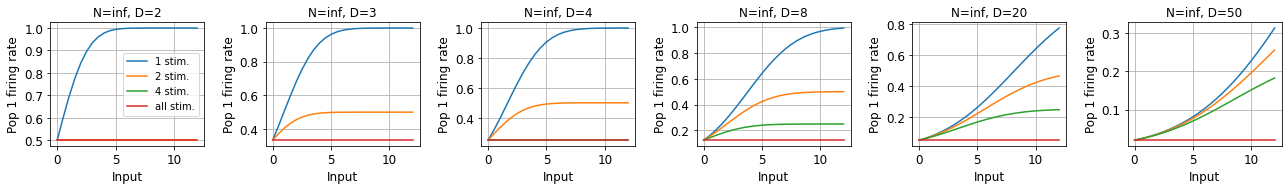

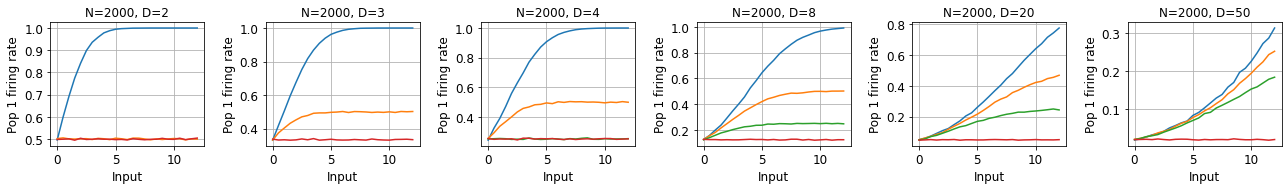

In [5]:
for cN, N in enumerate(NS):
    fig, axs = plt.subplots(1, len(DS), figsize=(3*len(DS), 2.75), tight_layout=True)
    for cD, (D, ax) in enumerate(zip(DS, axs)):
        for cNPPLN_STIM, NPPLN_STIM in enumerate(NPPLN_STIMS):
            ax.plot(U_SCALES, fr_1s[cNPPLN_STIM, cD, cN])
        ax.grid()
        set_plot(ax, x_label='Input', y_label='Pop 1 firing rate', title=f'N={N}, D={D}')
        if (cN, cD) == (0, 0):
            ax.legend([f'{NPPLN_STIM} stim.' for NPPLN_STIM in NPPLN_STIMS])

In [6]:
np.save('data/input_response/mft_input_rsp.npy', np.array([
    {
        'NPPLN_STIMS': NPPLN_STIMS,
        'DS': DS,
        'U_SCALES': U_SCALES,
        'NS': NS,
        'fr_1s': fr_1s,
    }
]))